In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.legendFontSize = 16
CHI_TETRAHEDRAL_CW = Chem.ChiralType.CHI_TETRAHEDRAL_CW
CHI_TETRAHEDRAL_CCW = Chem.ChiralType.CHI_TETRAHEDRAL_CCW

from magicmethyl.magicmethyl import methylate
from magicmethyl.utils import show_analogs

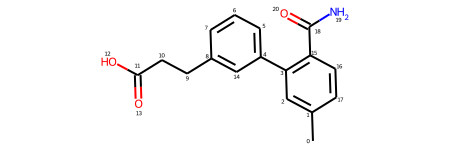

there are 14 analogs

Cc1ccc(C(N)=O)c(-c2cccc([C@H](C)CC(=O)O)c2)c1


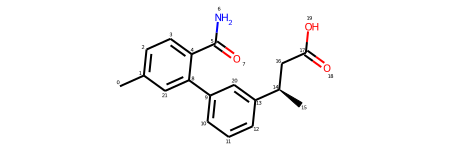

CCc1ccc(C(N)=O)c(-c2cccc(CCC(=O)O)c2)c1


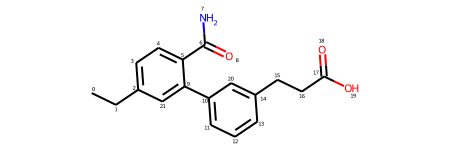

Cc1cc(C)c(C(N)=O)c(-c2cccc(CCC(=O)O)c2)c1


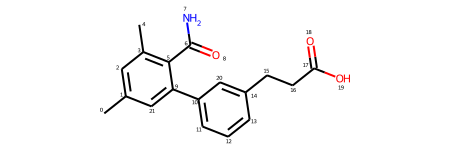

Cc1ccc(C(N)=O)c(-c2cccc(CCC(=O)O)c2)c1C


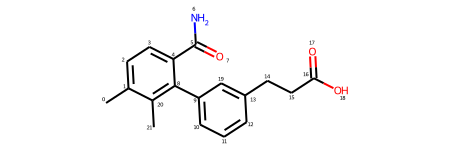

Cc1ccc(C(N)=O)c(-c2ccc(C)c(CCC(=O)O)c2)c1


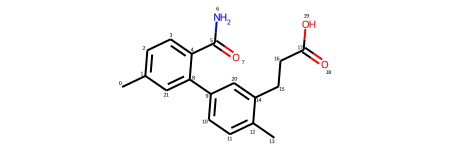

Cc1ccc(C(N)=O)c(-c2cccc(CCC(=O)O)c2C)c1


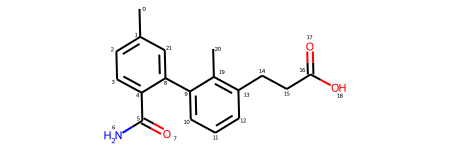

Cc1ccc(C(N)=O)c(-c2cccc(C[C@@H](C)C(=O)O)c2)c1


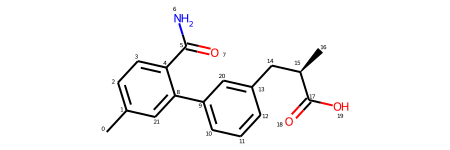

Cc1cc(C(N)=O)c(-c2cccc(CCC(=O)O)c2)cc1C


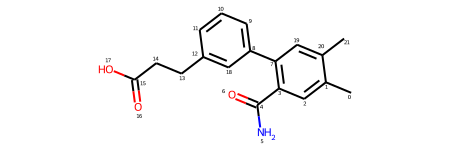

Cc1ccc(C(N)=O)c(-c2cccc(C[C@H](C)C(=O)O)c2)c1


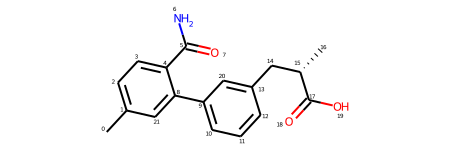

Cc1cc(CCC(=O)O)cc(-c2cc(C)ccc2C(N)=O)c1


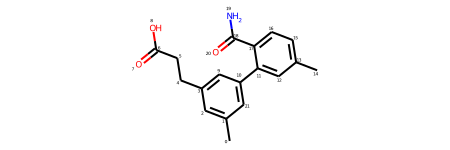

Cc1ccc(C(N)=O)c(-c2cc(CCC(=O)O)ccc2C)c1


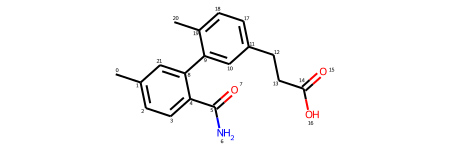

CNC(=O)c1ccc(C)cc1-c1cccc(CCC(=O)O)c1


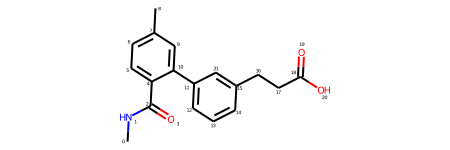

COC(=O)CCc1cccc(-c2cc(C)ccc2C(N)=O)c1


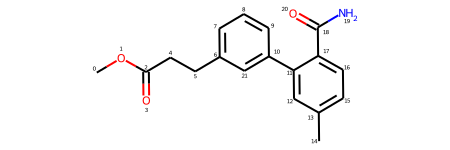

Cc1ccc(C(N)=O)c(-c2cccc([C@@H](C)CC(=O)O)c2)c1


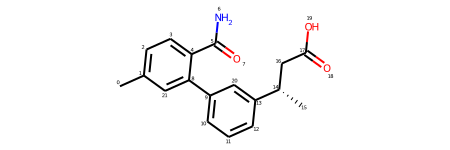

In [5]:
# smi = 'ONC(=O)C1CC=CC1'
# smi = 'CN(CCN1CCCC1)C(=O)CC1=CC=C(Cl)C(Cl)=C1'
# smi = 'CCCC1=CC2=C(OC=CC2=O)C=C1OC(C)=O'
# smi = 'CC1=CC(C(=O)N2CCC[C@@H](COC3=CC(C)=C(F)C=C3)C2)=C(C=C1)N1N=CC=N1'
smi = 'CC1=CC(C2=CC=CC(CCC(O)=O)=C2)=C(C=C1)C(N)=O'
mol = Chem.MolFromSmiles(smi)
display(mol)
show_analogs(methylate(smi))